<a href="https://colab.research.google.com/github/anshupandey/Deep-Learning-for-structured-Data/blob/main/28082021_time_series_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from numpy.random import seed
import tensorflow
import random
import os
seed(1)
tensorflow.random.set_seed(1)
random.seed(1)
os.environ['PYTHONHASHSEED'] = '0'

In [ ]:
#load dataset
df = pd.read_csv(r"E:\MLIoT\ML\dataset\civil-aircraft-arrivals-departures-passengers-and-mail-changi-airport-monthly (1)\civil-aircraft-arrivals-departures-and-passengers-changi-airport-monthly.csv")
df.shape

(974, 3)

In [ ]:
df.head()

,month,level_1,value
0,1980-01,Total Aircraft Arrivals And Departures,6501
1,1980-01,Total Passengers,566879
2,1980-02,Total Aircraft Arrivals And Departures,6112
3,1980-02,Total Passengers,552263
4,1980-03,Total Aircraft Arrivals And Departures,6391


In [ ]:
df.tail()

,month,level_1,value
969,2020-05,Total Passengers,24504
970,2020-06,Total Aircraft Arrivals And Departures,4779
971,2020-06,Total Passengers,48241
972,2020-07,Total Aircraft Arrivals And Departures,5247
973,2020-07,Total Passengers,85981


In [ ]:
df = df[df.level_1=='Total Passengers']
df.shape

(487, 3)

In [ ]:
df.head()

,month,level_1,value
1,1980-01,Total Passengers,566879
3,1980-02,Total Passengers,552263
5,1980-03,Total Passengers,597644
7,1980-04,Total Passengers,561218
9,1980-05,Total Passengers,587003


In [ ]:
df.month = pd.to_datetime(df.month)
df.index = df.month
df = df[["value"]]
df.head()

,value
month,
1980-01-01,566879
1980-02-01,552263
1980-03-01,597644
1980-04-01,561218
1980-05-01,587003


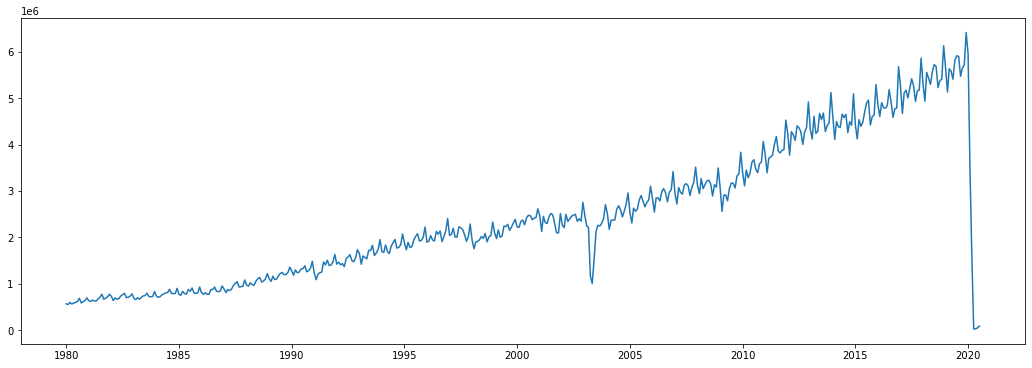

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(df)
plt.show()

# With sequence length = 1

In [ ]:
#taking data from 20005 to 2016 - 12 years of data
df2 = df[pd.to_datetime("01-01-2005"):pd.to_datetime("12-01-2016")]
df2.shape

(144, 1)

In [ ]:
df2.head()

,value
month,
2005-01-01,2532594
2005-02-01,2307000
2005-03-01,2628115
2005-04-01,2561634
2005-05-01,2608397


In [ ]:
df2.tail()

,value
month,
2016-08-01,4923309
2016-09-01,4584383
2016-10-01,4768937
2016-11-01,4784818
2016-12-01,5676648


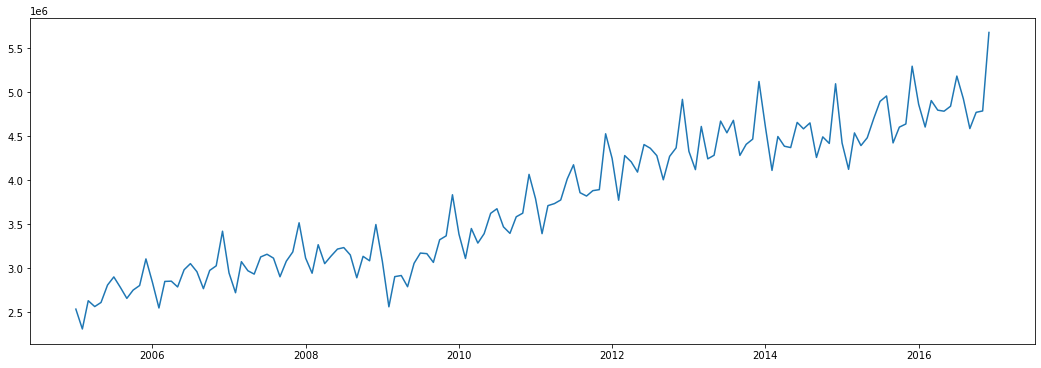

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(df2)
plt.show()

In [ ]:
df2['feature'] = df2.value.shift(1)
df2 = df2[['feature','value']]
df2.head(10)

<ipython-input-14-04de49acc417>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['feature'] = df2.value.shift(1)


,feature,value
month,,
2005-01-01,NaN,2532594
2005-02-01,2532594.0,2307000
2005-03-01,2307000.0,2628115
2005-04-01,2628115.0,2561634
2005-05-01,2561634.0,2608397
2005-06-01,2608397.0,2806185
2005-07-01,2806185.0,2898656
2005-08-01,2898656.0,2780426
2005-09-01,2780426.0,2654697


In [ ]:
df2.dropna(inplace=True)
x = df2.feature
y = df2.value
x = np.array(x).reshape(-1,1,1) # reshaping input data into - samples,timestamps,features
print(x.shape)
print(y.shape)

(143, 1, 1)
(143,)


In [ ]:
from tensorflow.keras import models,layers

In [ ]:
input_layer = layers.Input(shape=(1,1)) # shape = (timestamps,features)
lstm_layer = layers.LSTM(20,activation='relu',return_sequences=False)(input_layer)
dense = layers.Dense(30,activation='relu')(lstm_layer)
op_layer = layers.Dense(1)(dense)

model = models.Model(inputs=input_layer,outputs=op_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 30)                630       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________


### How parameters are calculated for LSTM layer

#### Understanding number of parameters for an RNN Layer
Consider - 
    x = number of input features
    h = number of neurons in RNN layer
    Note: number of parameters(weights and bias) do not depend on the size of sequence, i.e. the number of timestamps
    
    1. number of weights between input and hidden(RNN) layer = x * h
    2. As previous instance of output produced by RNN layer neuron will also be taken as an input(recurrent input), so total number of inputs to the hidden(RNN layer) layer is = x+h
    3. Now statement 1 above can rewritten as total number of weights between input layer and hidden layer (RNN layer) = total inputs (real inputs(x) + recurrent inputs(h)) * number of hidden neurons (h) = (x+h) * h
    4. total bias with each computational neuron = h
    5. total parameters = weights + bias = ((x+h)*h) + h
    
#### Understanding number of parameters for an LSTM Layer

<img src="https://i.stack.imgur.com/aTDpS.png" width="500" height="200">

    As it can be seen in above image there are 4 steps of computations in an LSTM cell
    1. for forget gate - ft
    2. for input gate - it
    3. for cell current state value = ct
    4. for output gate ot
    
    so total parameters in LSTM layer = 4 * parameters of an RNN layer
                                      = 4 * [ ((x+h)*h) + h ]
                                      
    In this case, input features(x) = 1
    number of LSTM cells taken (h) = 20
    so total paramers = 4 * [ ( (x+h)*h ) + h )]
                      = 4 * [ ( (1+20)*20 ) + 20 )]
                       = 4 * [420+20]
                       = 4 * 440
                       = 1760

In [ ]:
model.compile(loss='mae',optimizer='adam')
model.fit(x,y,batch_size=10,shuffle=False,epochs=100)

Epoch 1/100
15/15 [==============================] - 3s 3ms/step - loss: 3735887.0000
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 3694358.7500
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 3648325.7500
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 3582512.5000
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 3484669.0000
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 3344561.5000
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 3151769.0000
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 2896370.5000
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 2568298.2500
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 2157146.5000
Epoch 11/100
15/15 [==============================] - 0s 3ms/step - loss: 1652073.2500
Epoch 12/100
15/15 [==============================] 

15/15 [==============================] - 0s 2ms/step - loss: 229359.8906
Epoch 97/100
15/15 [==============================] - 0s 2ms/step - loss: 229133.0000
Epoch 98/100
15/15 [==============================] - 0s 2ms/step - loss: 229162.7344
Epoch 99/100
15/15 [==============================] - 0s 2ms/step - loss: 229463.4062
Epoch 100/100
15/15 [==============================] - 0s 2ms/step - loss: 230585.5156


In [ ]:
df2.tail(1)

,feature,value
month,,
2016-12-01,4784818.0,5676648


In [ ]:
ip = np.array(df2.tail(1).value).reshape(1,1,1)

In [ ]:
model.predict(ip)

array([[5700194.5]], dtype=float32)

In [ ]:
forecast = []
for i in range(12):
    pred = model.predict(ip)
    forecast.append(pred)
    ip = pred.reshape(1,1,1)
    

In [ ]:
forecast = np.array(forecast).reshape(-1,1)

In [ ]:
forecast

array([[5700194.5],
       [5723839. ],
       [5747581. ],
       [5771421. ],
       [5795360.5],
       [5819399. ],
       [5843537.5],
       [5867776.5],
       [5892116. ],
       [5916556.5],
       [5941098. ],
       [5965741.5]], dtype=float32)

In [ ]:
actuals = df[pd.to_datetime("01-01-2017"):pd.to_datetime("12-01-2017")]
actuals

,value
month,
2017-01-01,5256301
2017-02-01,4669729
2017-03-01,5112576
2017-04-01,5168548
2017-05-01,5003578
2017-06-01,5208779
2017-07-01,5415734
2017-08-01,5265703
2017-09-01,4927561


In [ ]:
forecast = pd.DataFrame(forecast,index=actuals.index,columns=['value'])
forecast

,value
month,
2017-01-01,5700194.5
2017-02-01,5723839.0
2017-03-01,5747581.0
2017-04-01,5771421.0
2017-05-01,5795360.5
2017-06-01,5819399.0
2017-07-01,5843537.5
2017-08-01,5867776.5
2017-09-01,5892116.0


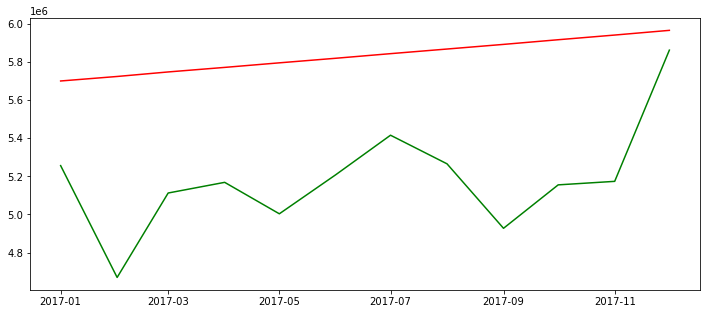

In [ ]:

plt.figure(figsize=(12,5))
plt.plot(actuals,c='g')
plt.plot(forecast,c='r')
plt.show()

# With sequence length = 12

In [ ]:
#taking data from 2004 to 2018 - 15 years of data
df2 = df[pd.to_datetime("01-01-2004"):pd.to_datetime("12-01-2018")]
df2.shape

(180, 1)

In [ ]:
df2.head()

,value
month,
2004-01-01,2516148
2004-02-01,2173157
2004-03-01,2365455
2004-04-01,2370567
2004-05-01,2375387


In [ ]:
df2.tail()

,value
month,
2018-08-01,5682688
2018-09-01,5225903
2018-10-01,5376234
2018-11-01,5408993
2018-12-01,6127843


In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
mm.fit(df2)
df2.value = mm.transform(df2)
df2.head()

C:\Users\anshu\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,value
month,
2004-01-01,0.086730
2004-02-01,0.000000
2004-03-01,0.048625
2004-04-01,0.049918
2004-05-01,0.051137


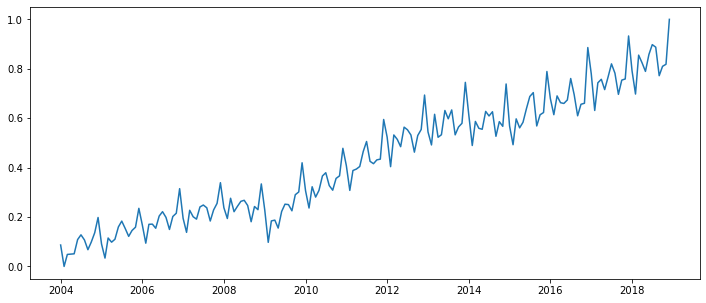

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df2)
plt.show()

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
x,y = split_sequence(df2.value,n_steps=12)
print(x.shape)

(168, 12)


In [ ]:
x = x.reshape(-1,12,1)
x.shape

(168, 12, 1)

In [ ]:
from tensorflow.keras import models,layers

In [ ]:
input_layer = layers.Input(shape=(12,1)) # shape = (timestamps,features)
lstm_layer = layers.LSTM(50,activation='relu',return_sequences=True)(input_layer)
lstm_layer = layers.LSTM(50,activation='relu',return_sequences=False)(lstm_layer)
#dense = layers.Dense(40,activation='relu')(lstm_layer)
op_layer = layers.Dense(1)(lstm_layer)

model = models.Model(inputs=input_layer,outputs=op_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mae',optimizer='adam')
model.fit(x,y,batch_size=24,shuffle=False,epochs=500)
model.fit(x,y,batch_size=36,shuffle=False,epochs=500)
model.fit(x,y,batch_size=48,shuffle=False,epochs=500)

Epoch 1/500
7/7 [==============================] - 3s 9ms/step - loss: 0.4110
Epoch 2/500
7/7 [==============================] - 0s 9ms/step - loss: 0.3075
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1293
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1128
Epoch 5/500
7/7 [==============================] - 0s 8ms/step - loss: 0.1172
Epoch 6/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0874
Epoch 7/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0683
Epoch 8/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0699
Epoch 9/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0555
Epoch 10/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0527
Epoch 11/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0492
Epoch 12/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0486
Epoch 13/500
7/7 [==============================] - 0s 8ms/st

7/7 [==============================] - 0s 7ms/step - loss: 0.0458
Epoch 105/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0427
Epoch 106/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0451
Epoch 107/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0434
Epoch 108/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0442
Epoch 109/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0420
Epoch 110/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0419
Epoch 111/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0417
Epoch 112/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0420
Epoch 113/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0416
Epoch 114/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0421
Epoch 115/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0417
Epoch 116/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 8ms/step - loss: 0.0444
Epoch 207/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0384
Epoch 208/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0374
Epoch 209/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0397
Epoch 210/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0391
Epoch 211/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0383
Epoch 212/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0373
Epoch 213/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0390
Epoch 214/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0392
Epoch 215/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0378
Epoch 216/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0361
Epoch 217/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0389
Epoch 218/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 9ms/step - loss: 0.0331
Epoch 309/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0321
Epoch 310/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0333
Epoch 311/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0323
Epoch 312/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0326
Epoch 313/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0312
Epoch 314/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0315
Epoch 315/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0314
Epoch 316/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0322
Epoch 317/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0317
Epoch 318/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0316
Epoch 319/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0304
Epoch 320/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 9ms/step - loss: 0.0316
Epoch 411/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0298
Epoch 412/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0291
Epoch 413/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0287
Epoch 414/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0289
Epoch 415/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0287
Epoch 416/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0284
Epoch 417/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0286
Epoch 418/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0293
Epoch 419/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0294
Epoch 420/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0332
Epoch 421/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0334
Epoch 422/500
7/7 [==============================] 

5/5 [==============================] - 0s 10ms/step - loss: 0.0265
Epoch 13/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0262
Epoch 14/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0264
Epoch 15/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0261
Epoch 16/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0260
Epoch 17/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0264
Epoch 18/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0263
Epoch 19/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0265
Epoch 20/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0257
Epoch 21/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0268
Epoch 22/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0265
Epoch 23/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0289
Epoch 24/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 11ms/step - loss: 0.0248
Epoch 115/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0247
Epoch 116/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0253
Epoch 117/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0254
Epoch 118/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0255
Epoch 119/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0280
Epoch 120/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0245
Epoch 121/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0233
Epoch 122/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0253
Epoch 123/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0255
Epoch 124/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0264
Epoch 125/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0278
Epoch 126/500
5/5 [=======================

5/5 [==============================] - 0s 11ms/step - loss: 0.0247
Epoch 216/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0237
Epoch 217/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0238
Epoch 218/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0289
Epoch 219/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0229
Epoch 220/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0236
Epoch 221/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0269
Epoch 222/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0249
Epoch 223/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0234
Epoch 224/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0237
Epoch 225/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0230
Epoch 226/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0252
Epoch 227/500
5/5 [=======================

5/5 [==============================] - 0s 10ms/step - loss: 0.0220
Epoch 317/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0223
Epoch 318/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0226
Epoch 319/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0231
Epoch 320/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0243
Epoch 321/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0287
Epoch 322/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0260
Epoch 323/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0245
Epoch 324/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0246
Epoch 325/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0252
Epoch 326/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0224
Epoch 327/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0225
Epoch 328/500
5/5 [=======================

5/5 [==============================] - 0s 10ms/step - loss: 0.0222
Epoch 418/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0242
Epoch 419/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0218
Epoch 420/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0217
Epoch 421/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0218
Epoch 422/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0226
Epoch 423/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0234
Epoch 424/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0234
Epoch 425/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0234
Epoch 426/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0245
Epoch 427/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0214
Epoch 428/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0207
Epoch 429/500
5/5 [=======================

4/4 [==============================] - 0s 12ms/step - loss: 0.0211
Epoch 19/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0202
Epoch 20/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0207
Epoch 21/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0219
Epoch 22/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0224
Epoch 23/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0204
Epoch 24/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0217
Epoch 25/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0203
Epoch 26/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0203
Epoch 27/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0205
Epoch 28/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0200
Epoch 29/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0195
Epoch 30/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 12ms/step - loss: 0.0211
Epoch 121/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0200
Epoch 122/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0196
Epoch 123/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0196
Epoch 124/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0214
Epoch 125/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0197
Epoch 126/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0199
Epoch 127/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0194
Epoch 128/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0224
Epoch 129/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0208
Epoch 130/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0209
Epoch 131/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0203
Epoch 132/500
4/4 [=======================

4/4 [==============================] - 0s 13ms/step - loss: 0.0201
Epoch 222/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0206
Epoch 223/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0185
Epoch 224/500
4/4 [==============================] - 0s 14ms/step - loss: 0.0193
Epoch 225/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0220
Epoch 226/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0210
Epoch 227/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0194
Epoch 228/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0189
Epoch 229/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0195
Epoch 230/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0191
Epoch 231/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0193
Epoch 232/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0190
Epoch 233/500
4/4 [=======================

4/4 [==============================] - 0s 15ms/step - loss: 0.0204
Epoch 323/500
4/4 [==============================] - 0s 14ms/step - loss: 0.0212
Epoch 324/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0200
Epoch 325/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0212
Epoch 326/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0205
Epoch 327/500
4/4 [==============================] - 0s 13ms/step - loss: 0.0209
Epoch 328/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0189
Epoch 329/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0187
Epoch 330/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 331/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0216
Epoch 332/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0190
Epoch 333/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0196
Epoch 334/500
4/4 [=======================

4/4 [==============================] - 0s 12ms/step - loss: 0.0184
Epoch 424/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0213
Epoch 425/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0193
Epoch 426/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0185
Epoch 427/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0179
Epoch 428/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0182
Epoch 429/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 430/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0206
Epoch 431/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0203
Epoch 432/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0184
Epoch 433/500
4/4 [==============================] - 0s 12ms/step - loss: 0.0205
Epoch 434/500
4/4 [==============================] - 0s 11ms/step - loss: 0.0211
Epoch 435/500
4/4 [=======================

In [ ]:
df2.tail(1)

,value
month,
2018-12-01,1.0


In [ ]:
ip = df2[pd.to_datetime("01-01-2018"):pd.to_datetime("12-01-2018")]
ip = np.array(ip).reshape(1,12,1)
ip.shape

(1, 12, 1)

In [ ]:
ip

array([[[0.791588  ],
        [0.6977009 ],
        [0.85517788],
        [0.82372861],
        [0.78939845],
        [0.85787291],
        [0.89765332],
        [0.88743607],
        [0.77193132],
        [0.80994471],
        [0.8182283 ],
        [1.        ]]])

In [ ]:
model.predict(ip)

array([[0.89624023]], dtype=float32)

In [ ]:
forecast = []
for i in range(12):
    pred = model.predict(ip)
    forecast.append(pred)
    ip = ip.tolist()[0]
    ip.pop(0)
    ip.append(pred[0])
    ip = np.array(ip).reshape(1,12,1)

In [ ]:
forecast = np.array(forecast).reshape(-1,1)

In [ ]:
actuals = df[pd.to_datetime("01-01-2019"):pd.to_datetime("12-01-2019")]
actuals

,value
month,
2019-01-01,5656076
2019-02-01,5131807
2019-03-01,5630780
2019-04-01,5580503
2019-05-01,5407308
2019-06-01,5816089
2019-07-01,5910782
2019-08-01,5900629
2019-09-01,5469342


In [ ]:
forecast = pd.DataFrame(forecast,index=actuals.index,columns=['value'])
forecast

,value
month,
2019-01-01,0.896240
2019-02-01,0.775736
2019-03-01,0.931188
2019-04-01,0.914091
2019-05-01,0.870913
2019-06-01,0.964167
2019-07-01,0.965025
2019-08-01,0.970855
2019-09-01,0.861178


In [ ]:
forecast.value = mm.inverse_transform(forecast)
forecast

,value
month,
2019-01-01,5717505.5
2019-02-01,5240951.0
2019-03-01,5855712.0
2019-04-01,5788098.5
2019-05-01,5617345.5
2019-06-01,5986133.5
2019-07-01,5989526.0
2019-08-01,6012585.0
2019-09-01,5578846.5


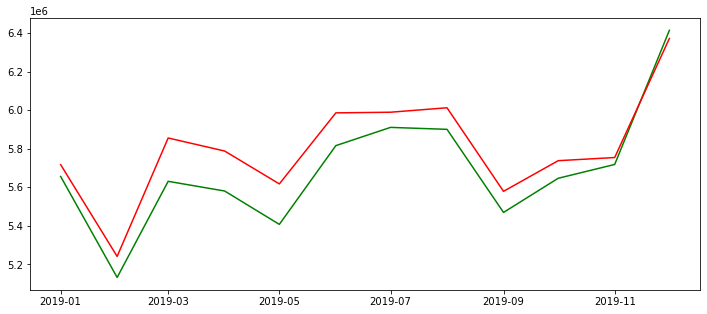

In [ ]:

plt.figure(figsize=(12,5))
plt.plot(actuals,c='g')
plt.plot(forecast,c='r')
plt.show()